# **Tabular Playground Series - Aug 2022**
##### Demonstrating ML skills on an approachable dataset

### **Importing Necessary Modules & Packages**

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from pathlib import Path
INPUT_PATH = Path("/kaggle/input/tabular-playground-series-aug-2022")

### **Modifying & Visualizing Data** 

In [25]:
# reading .csv files with pandas 
train_df = pd.read_csv("../input/tabular-playground-series-aug-2022/train.csv")
train_df = train_df.reset_index().set_index('id').drop('index', axis=1)
test_df = pd.read_csv("../input/tabular-playground-series-aug-2022/test.csv")
test_df = test_df.reset_index().set_index('id').drop('index', axis=1)

# removing some columns with high distribution mismatch
train_df = train_df.drop(['product_code', 'attribute_3', 'attribute_2', 'attribute_1', 'attribute_0', 'measurement_1', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_16'], axis=1)
test_df = test_df.drop(['product_code', 'attribute_3', 'attribute_2', 'attribute_1', 'attribute_0', 'measurement_1', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_16'], axis=1)

# product_code is bad...drop
cat_cols = list(train_df.select_dtypes(include=['object']).columns)
for c in cat_cols:
    print(f'{c} Train: {train_df[c].value_counts()}')
    print(f'{c} Test: {test_df[c].value_counts()}')
cat_cols = set(cat_cols) - set(('product_code',))
cat_cols = list(cat_cols)

float_cols = train_df.select_dtypes(include=['float64']).columns
int_cols = set(train_df.select_dtypes(include=['int64']).columns) - set(cat_cols)
int_cols = list(int_cols)

print(train_df.head())
print(float_cols)
print(int_cols)

    loading  measurement_0  measurement_2  measurement_3  measurement_4  \
id                                                                        
0     80.10              7              4         18.040         12.518   
1     84.89             14              3         18.213         11.540   
2     82.43             12              5         18.057         11.652   
3    101.07             13              6         17.295         11.188   
4    188.06              9              8         19.346         12.950   

    measurement_5  measurement_6  measurement_7  measurement_8  measurement_9  \
id                                                                              
0          15.748         19.292         11.739         20.155         10.672   
1          17.717         17.893         12.748         17.889         12.448   
2          16.738         18.240         12.718         18.288         12.715   
3          18.576         18.339         12.583         19.060       

In [26]:
Y = train_df.failure
X = train_df.drop('failure', axis=1)
X_test = test_df

In [27]:
float_transformer = Pipeline(
    steps=[("imputer", IterativeImputer(initial_strategy='median')),
           ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", float_transformer, float_cols),
        ("cat", categorical_transformer, list(cat_cols)),
    ],
    remainder='passthrough'
)

preprocessor.fit(X)
trans_X = preprocessor.transform(X)
trans_X_test = preprocessor.transform(X_test)
trans_X_df = pd.DataFrame(trans_X, index=X.index)
trans_X_test_df = pd.DataFrame(trans_X_test, index=X_test.index)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


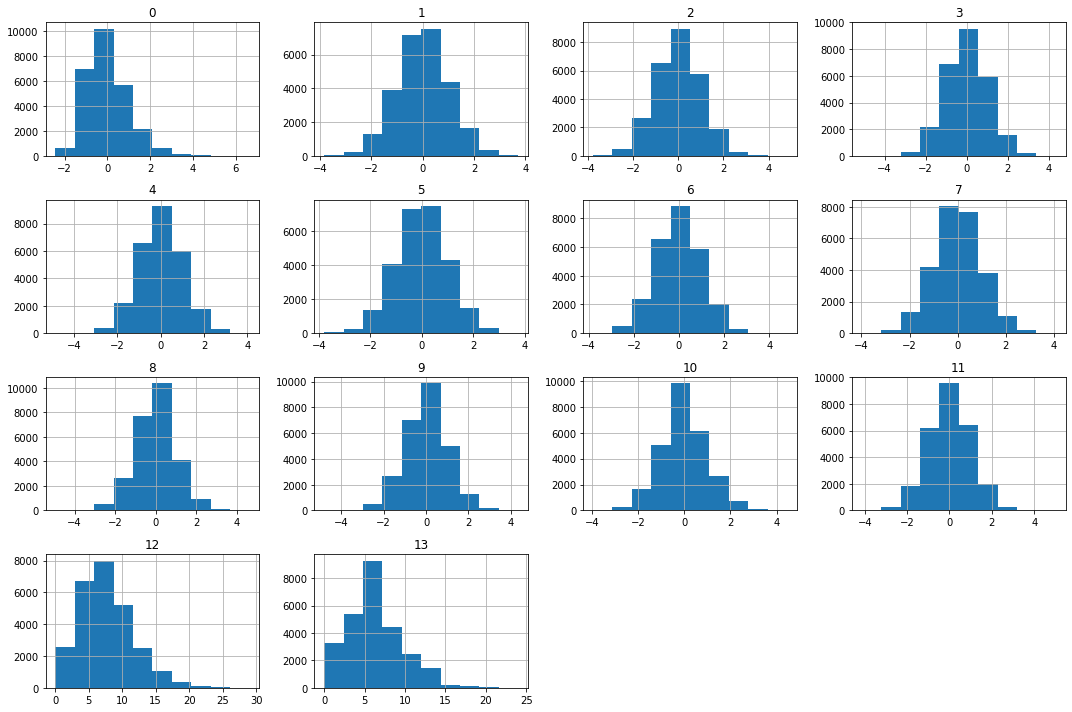

In [28]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
trans_X_df.hist(ax=ax)
fig.tight_layout()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


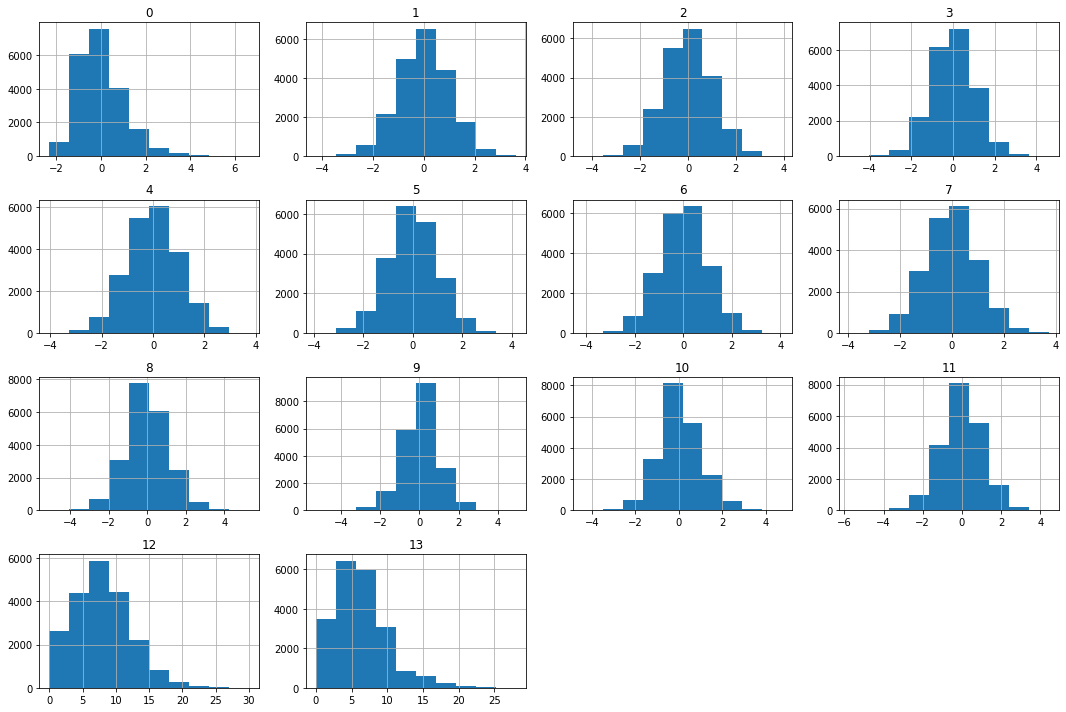

In [29]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
trans_X_test_df.hist(ax=ax)
fig.tight_layout()

In [30]:
X_train, X_val, Y_train, Y_val = train_test_split(trans_X_df, Y, test_size=0.15)
print(f'train {len(X_train)} test {len(X_val)}')
print(trans_X_test_df.dtypes)
print(Y_train.dtypes)
print(trans_X_test_df.head())

train 22584 test 3986
0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
dtype: object
int64
             0         1         2         3         4         5         6   \
id                                                                            
26570 -0.212542  1.522439 -1.574206  0.409801  0.668139 -0.120974 -0.369964   
26571 -0.368545  0.092034  0.197584  0.100339 -1.499118 -0.544966  0.345391   
26572 -0.403299  0.687533 -1.267258 -0.515551  0.689456  0.413318 -1.251634   
26573 -0.388883 -1.281034 -0.854955 -1.856553  1.098545 -0.418477 -0.075406   
26574  2.063928  0.016591  0.973565  0.555430 -1.721427  1.733868  0.117960   

             7         8         9         10        11    12    13  
id                                                                   
26570 -0.643463 -0.152160  0.539811 -0.841621 -0.547712   6.0   6.0 

In [35]:
from xgboost import cv, DMatrix, XGBClassifier
def modelfit(alg, X, Y, cv_folds=5, early_stopping_rounds=50):
    xgb_param = alg.get_xgb_params()
    xgtrain = DMatrix(X, label=Y)
    cvresult = cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    # fitting the algorithm
    alg.fit(X, Y)

In [34]:
best_model = XGBClassifier(max_depth=10,
                           eta=0.08576723343696911,
                           gamma=33.40638990503902,
                           min_child_weight=6.686242310457466,
                           error='auc',
                           objective='binary:logistic')

best_model = XGBClassifier(max_depth=10,
                           eta=0.08341671115463736,
                           gamma=31.557052328062216,
                           min_child_weight=52.091737470029166,
                           error='auc',
                           objective='binary:logistic')

best_model = XGBClassifier(max_depth=3,
                         eta=0.29954287405839364,
                         gamma=8.49459608336289,
                         min_child_weight=46.08510137796971,
                         reg_lambda=0.5208307829651955,
                         eval_metric='auc',
                         objective='binary:logistic')

### **Submission**

In [33]:
best_model = XGBClassifier(max_depth=11,
                           learning_rate=0.05828276372068748,
                           gamma=8.285407647140921,
                           min_child_weight=33.07632440003895,
                           reg_lambda=1.5618512121775718,
                           eval_metric='auc',
                           objective='binary:logistic')
modelfit(best_model, trans_X_df, Y,
         early_stopping_rounds=16)

pred = best_model.predict_proba(trans_X_test_df)
submission = pd.DataFrame({'failure': pred[:,1]}, index=trans_X_test_df.index)
submission.index.name = 'id'
submission.to_csv('submission.csv')